### QICK Standard ZCU111 Firmware + FFT/Spectrum Analysis

This firmware is a standard ZCU111 firmware (with less SGv6 though to make room for the BREAD Small logic) + BREAD Small chain. The BREAD small chain is a reduced FFT version (16k in place of 32k points) of the BREAD Real project.

BREAD Small part: this part has one input ADC and one output DAC. ADC is connected to Tile 224 Channel 0. DAC is connected to Tile 229 Channel 2.

See examples to extract data from the different points.

<!-- ![alt text](images/std_111_bread_small.png "Block Diagram") -->
![alt text](images/qick_tprocv2_111_fft_spectrum_diagram.png "Block Diagram")


In [1]:
import sys
import os
# print(sys.path)
# print(os.getcwd())
# sys.path.append(os.getcwd())

# Remote VSCode needs the current file path to be appended explicitly to find modules in files (os.getcwd() does not work)
# sys.path.append('/home/xilinx/jupyter_notebooks/qick-tools/spectrum_v1/soft')
sys.path.append('/home/dmartin2/qick-tools/spectrum_v1/soft')


In [2]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fftshift, fft

from qick import *
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

print(qick.get_version())

# from qick.spectrum import SpectrumSoc, DualChain
from spectrum import SpectrumSoc
# from qick.fft_helpers import *
from fft_helpers import *

import pynq
pynq.pl_server.global_state.clear_global_state()


0.2.369


In [ ]:
USE_PYRO = False

if USE_PYRO:
    from qick.pyro import make_proxy
    # soc, soccfg = make_proxy(ns_host="pynq4x2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
    # soc, soccfg = make_proxy(ns_host="pynq216-6.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
    # soc, soccfg = make_proxy(ns_host="pynq111-2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
    soc, soccfg = make_proxy(ns_host="pynq111-4.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")

else:
    # soc = SpectrumSoc(bitfile='/home/dmartin2/fw/qick_tprocv2_111_fft_spectrum_250826_1/pynq/std_111_bread_small.bit')
    # soc = SpectrumSoc(bitfile='/home/dmartin2/fw/qick_tprocv2_111_fft_spectrum_250918_1/qick_111.bit') # has hierarchies, couldn´t test it due to qick_lib version not supporting it
    soc = SpectrumSoc(bitfile='/home/dmartin2/fw/qick_tprocv2_111_fft_spectrum_250919_1/qick_111.bit') # works OK
    soccfg = soc

print(soccfg)


QICK running on ZCU111, software version 0.2.369

Firmware configuration (built Mon Oct  6 19:47:18 2025):

	Global clocks (MHz): tProc dispatcher timing 384.000, RF reference 204.800
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 0, DAC tile 1], [ADC tile 0, ADC tile 2, ADC tile 3]

	4 signal generator channels:
	0:	axis_signal_gen_v6 - fs=6144.000 Msps, fabric=384.000 MHz
		envelope memory: 65536 complex samples (10.667 us)
		32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0, or RF board DAC port 0
	1:	axis_signal_gen_v6 - fs=6144.000 Msps, fabric=384.000 MHz
		envelope memory: 65536 complex samples (10.667 us)
		32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1, or RF board DAC port 1
	2:	axis_signal_gen_v6 - fs=6144.000 Msps, fabric=384.000 MHz
		envelope memory: 16384 complex samples (2.667 us)
		32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2, or RF board DAC port 2
	3:	axis_signal_gen_v6 - fs=614

In [4]:
#########################
### Define dual chain ###
#########################
# chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][0])
chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][1])

fout: 500
F1 = 500.015, Y1 = -39.288


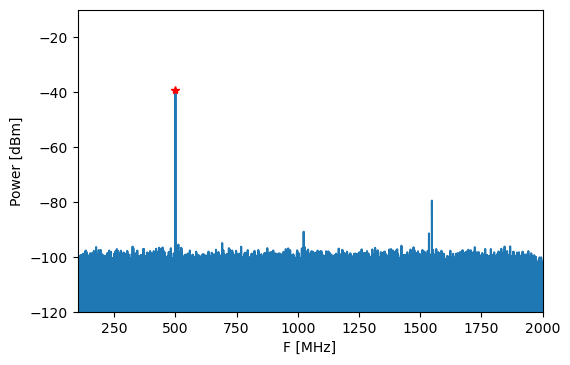

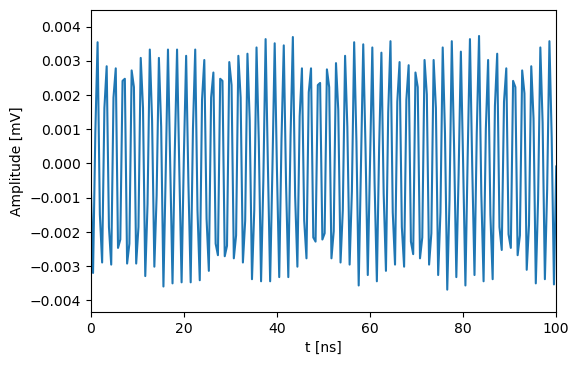

In [5]:
##########################################
### Simple Sine Loop-back (ADC output) ###
##########################################
# fout = np.random.randint(0,1000)
fout = 500
print("fout: %d"%(fout))
chain.set_tone(fout,verbose=True)

# Get data.
[xi,xq] = chain.get_data_adc()
x = xi + 1j*xq
# plt.figure(0)
# plt.plot(xi[:100])
# plt.plot(xq[:100])

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=100)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");
plt.xlim([100,2000])
plt.ylim([-120,-10])

# Time domain signal.
n = np.arange(len(x))
t = n/chain.fs
plt.figure(2,dpi=100)
plt.plot(1000*t,np.real(x))
plt.xlabel("t [ns]");
plt.ylabel("Amplitude [mV]");
plt.xlim([0,100]);

fout: 500
F1 = 500.002, Y1 = -21.165


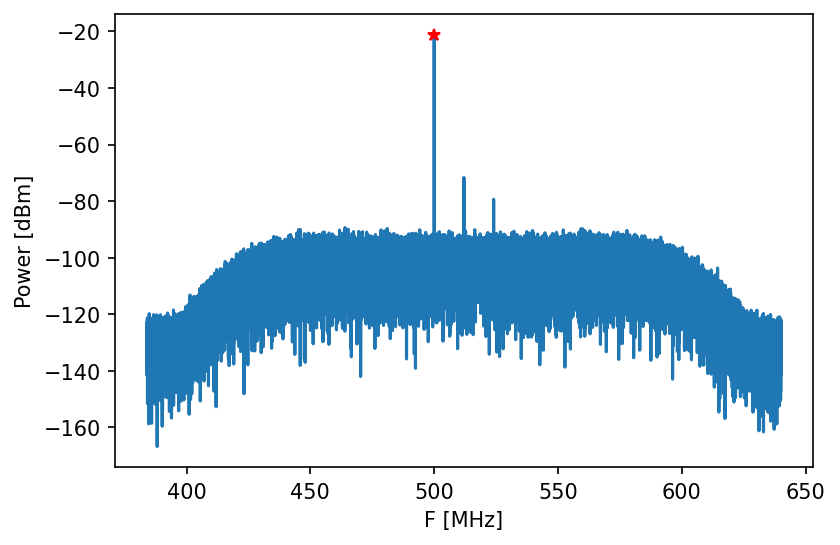

In [6]:
##########################################
### Simple Sine Loop-back (PFB output) ###
##########################################
# fout = np.random.randint(0,1000)
fout = 500
print("fout: %d"%(fout))
chain.set_tone(fout,verbose=True)

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

soc.axis_ddscic_v3_0.outsel(data="input", cic="no")

# Get data.
[xi,xq] = chain.get_bin_pfb(fout)
x = xi + 1j*xq
# plt.figure(0)
# plt.plot(xi[:100])
# plt.plot(xq[:100])

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(3,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

Iteration K = 0; Freq: 1024.000000
Iteration K = 1; Freq: 1152.000000
Iteration K = 2; Freq: 1280.000000
Iteration K = 3; Freq: 1408.000000
Iteration K = 4; Freq: 1536.000000
Iteration K = 5; Freq: 1664.000000
Iteration K = 6; Freq: 1792.000000
Iteration K = 7; Freq: 1920.000000
Iteration K = 8; Freq: 0.000000
Iteration K = 9; Freq: 128.000000
Iteration K = 10; Freq: 256.000000
Iteration K = 11; Freq: 384.000000
Iteration K = 12; Freq: 512.000000
Iteration K = 13; Freq: 640.000000
Iteration K = 14; Freq: 768.000000
Iteration K = 15; Freq: 896.000000
Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


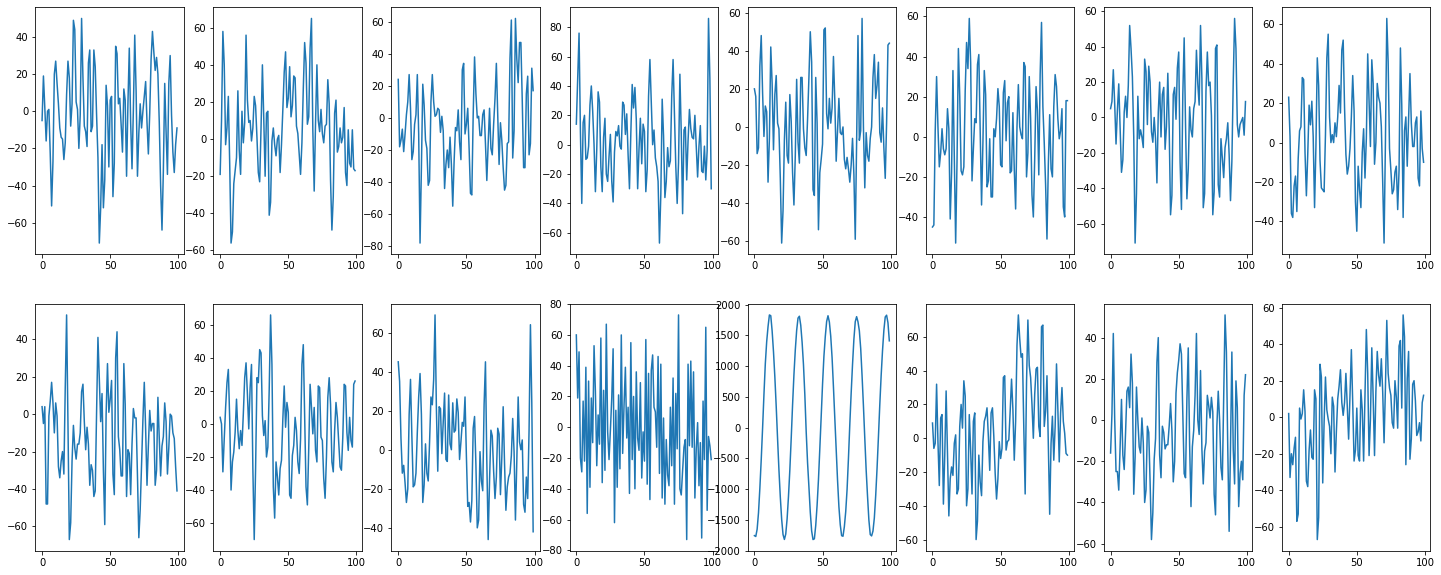

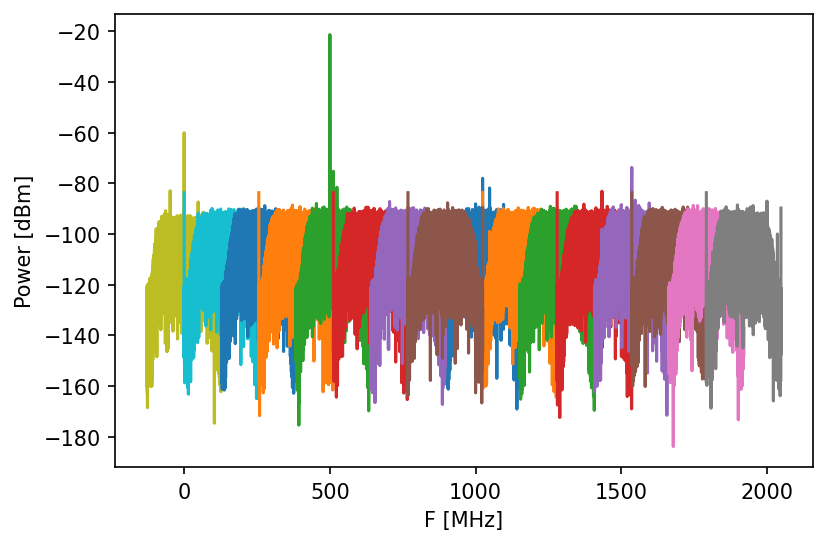

In [7]:
##########################################
### Channels Side-by-Side (PFB output) ###
##########################################
# Channels to plot.
K = np.arange(chain.nch)

# Frequency and amplitude vectors.
FF = []
AA = []

plt.figure(figsize=[25,10])

for KK in K:
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    print("Iteration K = %d; Freq: %f" % (KK, fck))  

    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    plt.subplot(2,8,KK+1)
    plt.plot(xi[:100])


plt.figure(4, dpi=150)

for KK in K:
    print("Iteration K = %d" %KK)  
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

fout: 183
F1 = 183.011, Y1 = -28.619


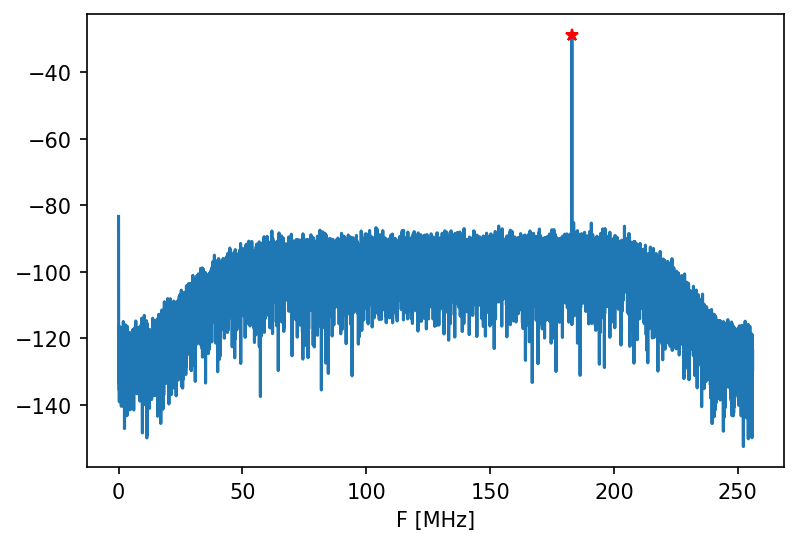

In [8]:
###########################################
### Simple Sine Loop-back (XFFT output) ###
###########################################
fout = np.random.randint(0,1000)
print("fout: %d"%(fout))
chain.set_tone(fout,verbose=True)

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_xfft(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Scale by FFT length.
x = x/soc.FFT_N

# Spectrum.
Y = fftshift(x)
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(5,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


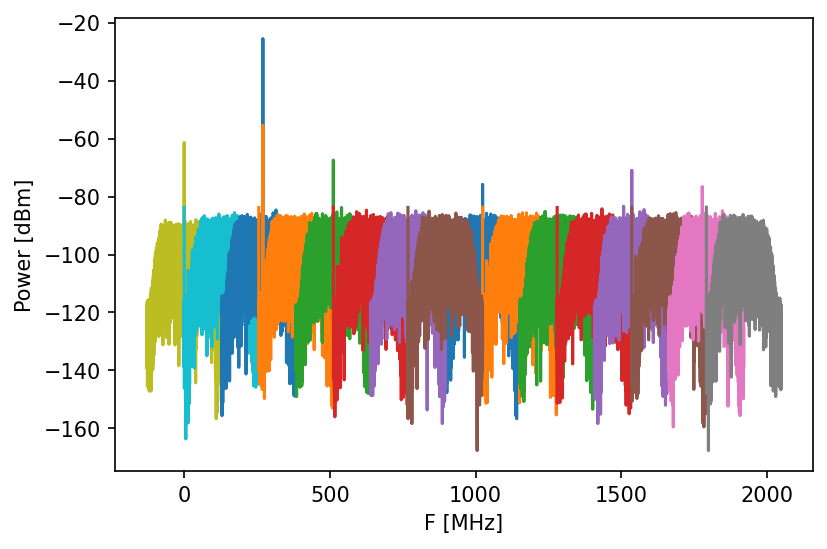

In [14]:
###########################################
### Channels Side-by-Side (XFFT output) ###
###########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(6,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.    
    [xi,xq] = chain.get_bin_xfft(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15
    
    # Scale by FFT length.
    x = x/soc.FFT_N

    # Spectrum.
    Y = fftshift(x)
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 183.001, Y1 = -28.586
FFT Resolution: 15.625 kHz


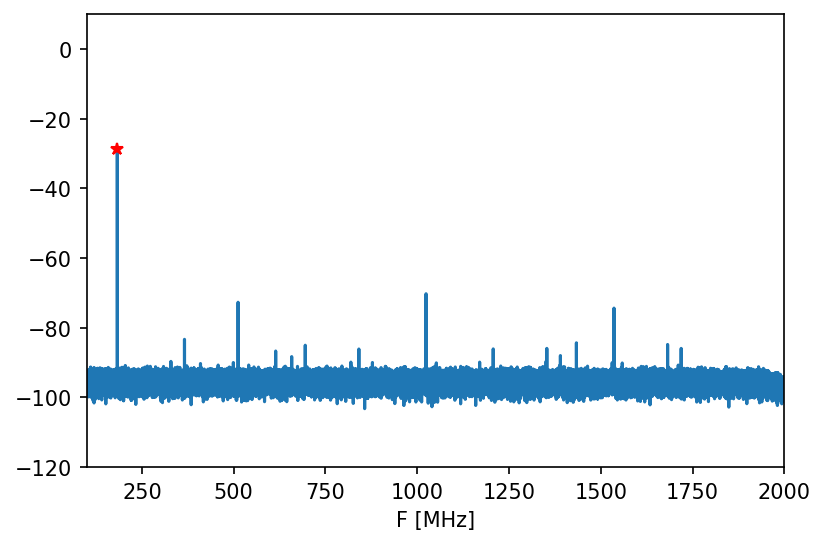

In [10]:
##########################################
### Simple Sine Loop-back (ACC output) ###
##########################################
# Number of averages.
N = 10

# Get data.
x = chain.get_data_acc(N)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(7,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.xlim([100,2000]);
plt.ylim([-120,10]);

print('FFT Resolution: {} kHz'.format(1000*soc['analysis'][0]['fs_ch']/soc.FFT_N))

pfb_channel: 10 / FC: 256
AbsPfbAnalysis: f = 270 MHz, fd = -754.0 MHz, k = 10
Peek found at F1 = 256.200, Y1 = -32.968
FFT Resolution: 19.53125 Hz


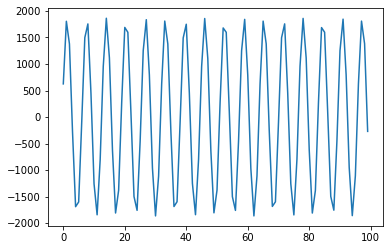

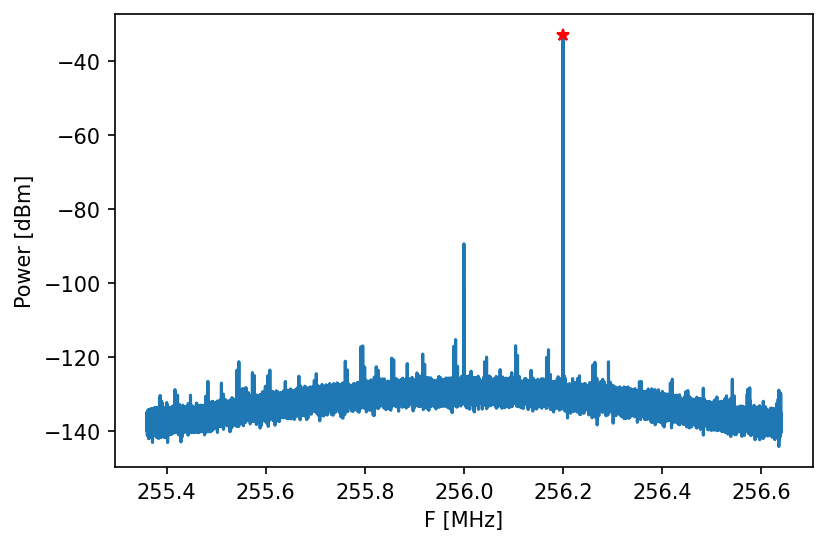

In [11]:
###############################
### Single Channel Zoom FFT ###
###############################
# Output frequency.
fout = 270
chain.set_tone(fout)

# Compute channel center frequency.
pfb_channel = chain.analysis.freq2ch(fout)
FC = chain.analysis.ch2freq(pfb_channel)
print("pfb_channel: %d / FC: %d"%(pfb_channel,FC))

# # DEBUG
# soc.axis_ddscic_v3_0.ddsfreq(f=10e6)
# soc.axis_ddscic_v3_0.outsel(data="dds", cic="no")
# [xi,xq] = chain.get_bin_pfb(fout, verbose=True)
# plt.figure()
# plt.plot(xi[:100])

# # DEBUG
# soc.axis_ddscic_v3_0.outsel(data="input", cic="no")
# [xi,xq] = chain.get_bin_pfb(fout, verbose=True)
# plt.figure()
# plt.plot(xi[:100])


# DDS + CIC configuration.
D=200
soc.axis_ddscic_v3_0.outsel(data="product", cic="yes")
soc.axis_ddscic_v3_0.decimation(D)
soc.axis_ddscic_v3_0.ddsfreq(f=14e6-200e3)
soc.axis_ddscic_v3_0.set_qprod(14) # quantization range for product 0-16
[xi,xq] = chain.get_bin_pfb(fout, verbose=True)
plt.figure()
plt.plot(xi[:100])

# Get data.
#x = soc.acc_zoom.single_shot(10)
x = soc.axis_accumulator_1.single_shot(10)

# Sampling frequency.
fs = chain.analysis.dict['chain']['fs_ch']/soc.axis_ddscic_v3_0.get_decimation()
F = np.linspace(-fs/2,fs/2,len(Y))


# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by window gain.
#x = x*(soc.axis_wxfft_65536_0.Aw)**2*(2**16)**2

# Scale by FFT length.
x = x/(soc.axis_accumulator_1.FFT_N)**2

# Spectrum.
Y = x
F = np.linspace(-fs/2,fs/2,len(Y))

# Normalize to dBm.
R = 50
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3))

# Max.
[F1,Y1] = findPeak(F,Y)
print('Peek found at F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1))

plt.figure(dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*')
plt.xlabel("F [MHz]")
plt.ylabel("Power [dBm]")

#print('FFT Resolution: {} Hz'.format(1000*1000*fs/soc.acc_zoom.FFT_N))
print('FFT Resolution: {} Hz'.format(1000*1000*fs/soc.axis_accumulator_1.FFT_N))

# Now let's play a little with the standard part of the FW.

### Hardware Configuration

You should cable the board in loopback, connecting one DAC to one ADC. You can set appropriate generator and readout numbers in the cell below, which will be used in `res_ch` and `ro_chs` entries in the program dictionaries below.

For example, for a ZCU111 you might connect DAC228_T0_CH0_P to ADC226_T2_CH0_P (these are the labels on the XM500 balun board). The DAC and ADC lists tell you that these are DAC tile 0, block 0, and ADC tile 2, block 0. The generator and readout lists tell you that these are driven by generator 0 and readout 0, and your QICK programs will reference those IDs.

In [12]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 500

  0%|          | 0/1 [00:00<?, ?it/s]

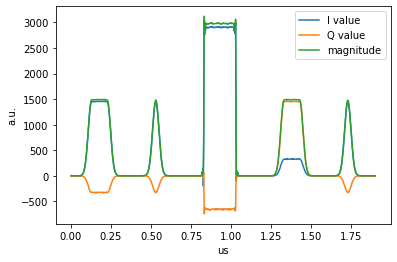

In [13]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=10)
iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");